In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram, butter, filtfilt
from IPython.display import Audio

/tmp/ipykernel_36/1116973655.py:43: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(f, P1, basefmt=" ", use_line_collection=True)


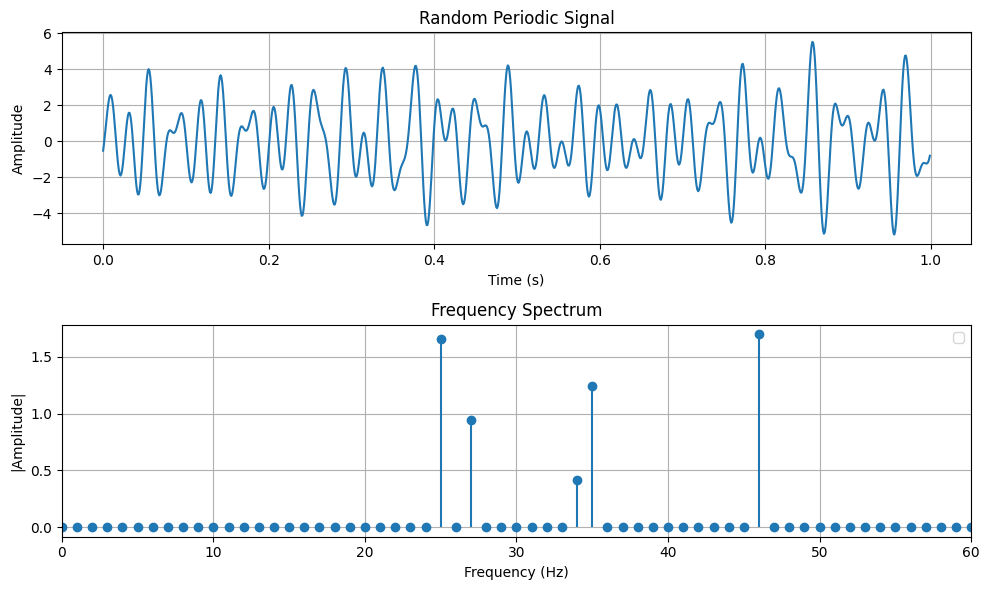

In [3]:
import numpy as np
import matplotlib.pyplot as plt


Fs = 1000           
T = 1/Fs            
L = 1000            
t = np.arange(0, L) * T  


N = np.random.randint(2, 6)
signal = np.zeros_like(t)
for k in range(N):
    freq = np.random.randint(5, 51)         
    amp = np.random.rand() * 2              
    phase = np.random.rand() * 2 * np.pi    
    signal += amp * np.sin(2*np.pi*freq*t + phase)


Y = np.fft.fft(signal)
P2 = np.abs(Y / L)                 
P1 = P2[:L//2+1]                   
P1[1:-1] = 2 * P1[1:-1]              
f = Fs * np.arange(0, L//2+1) / L    


threshold = 0.05 * np.max(P1)   
valid_indices = np.where(P1 > threshold)[0]
fund_index = valid_indices[0] if len(valid_indices) > 0 else 0
fund_freq = f[fund_index]
fund_amp = P1[fund_index]


plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, signal)
plt.title('Random Periodic Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2,1,2)
plt.stem(f, P1, basefmt=" ", use_line_collection=True)
#plt.scatter(fund_freq, fund_amp, color='red', zorder=3, label=f'Fundamental = {fund_freq:.1f} Hz')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Amplitude|')
plt.xlim(0, 60)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


![bell curve](https://i0.wp.com/www.msicertified.com/wp-content/uploads/2023/01/Standard_deviation_diagram.png)

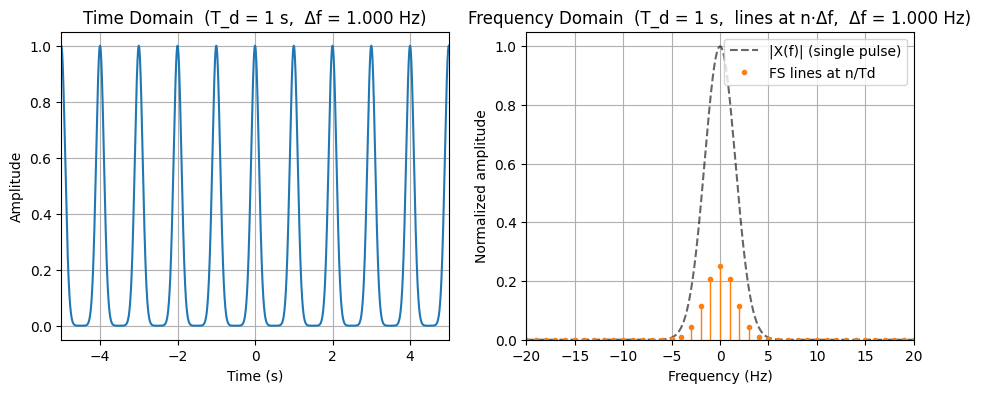

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib

matplotlib.rcParams['animation.html'] = 'jshtml'


Fs = 2000           
t_max = 10.0        
t = np.linspace(-t_max/2, t_max/2, int(Fs*t_max), endpoint=False)
sigma = 0.10      
single = np.exp(-t**2 / (2*sigma**2))


def X_gauss(f, sigma):
    return sigma*np.sqrt(2*np.pi) * np.exp(-2*(np.pi**2)*(sigma**2)*(f**2))


fmax = 20.0
f_cont = np.linspace(-fmax, fmax, 4000)
X_cont = np.abs(X_gauss(f_cont, sigma))
X_cont /= X_cont.max() 


periods = [1, 2, 4, 8, 16, 32, 64]


fig, (ax_t, ax_f) = plt.subplots(1, 2, figsize=(11, 4))


line_time, = ax_t.plot([], [], lw=1.5)
ax_t.set_title("Time Domain")
ax_t.set_xlabel("Time (s)")
ax_t.set_ylabel("Amplitude")
ax_t.set_xlim(-t_max/2, t_max/2) 
ax_t.set_ylim(-0.05, 1.05)
ax_t.grid(True)


ax_f.plot(f_cont, X_cont, 'k--', alpha=0.6, label="|X(f)| (single pulse)")
pts, = ax_f.plot([], [], 'o', ms=3, color='C1', label="FS lines at n/Td")
stem_holder = [None] 
ax_f.set_title("Frequency Domain")
ax_f.set_xlabel("Frequency (Hz)")
ax_f.set_ylabel("Normalized amplitude")
ax_f.set_xlim(-fmax, fmax)
ax_f.set_ylim(0, 1.05)
ax_f.grid(True)
ax_f.legend(loc="upper right")


def periodic_from_single(t, T_d, sigma):
    kmax = int(np.ceil((t_max/2 + 3*sigma)/T_d))
    y = np.zeros_like(t)
    for k in range(-kmax, kmax+1):
        y += np.exp(-(t - k*T_d)**2 / (2*sigma**2))
    return y


def update(frame):
    T_d = periods[frame]
    y = periodic_from_single(t, T_d, sigma)
    line_time.set_data(t, y)
    ax_t.set_title(f"Time Domain  (T_d = {T_d} s,  Δf = {1/T_d:.3f} Hz)")

    df = 1.0 / T_d
    nmax = int(np.floor(fmax / df))
    f_lines = np.arange(-nmax, nmax+1) * df
    amps = np.abs(X_gauss(f_lines, sigma))
    amps = amps / X_cont.max()


    pts.set_data(f_lines, amps)
    if stem_holder[0] is not None:
        stem_holder[0].remove()
    stem_holder[0] = ax_f.vlines(f_lines, 0, amps, color='C1', linewidth=1)

    ax_f.set_title(f"Frequency Domain  (T_d = {T_d} s,  lines at n·Δf,  Δf = {df:.3f} Hz)")
    return line_time, pts, stem_holder[0]

anim = FuncAnimation(fig, update, frames=len(periods), interval=1200, blit=False)
HTML(anim.to_jshtml())


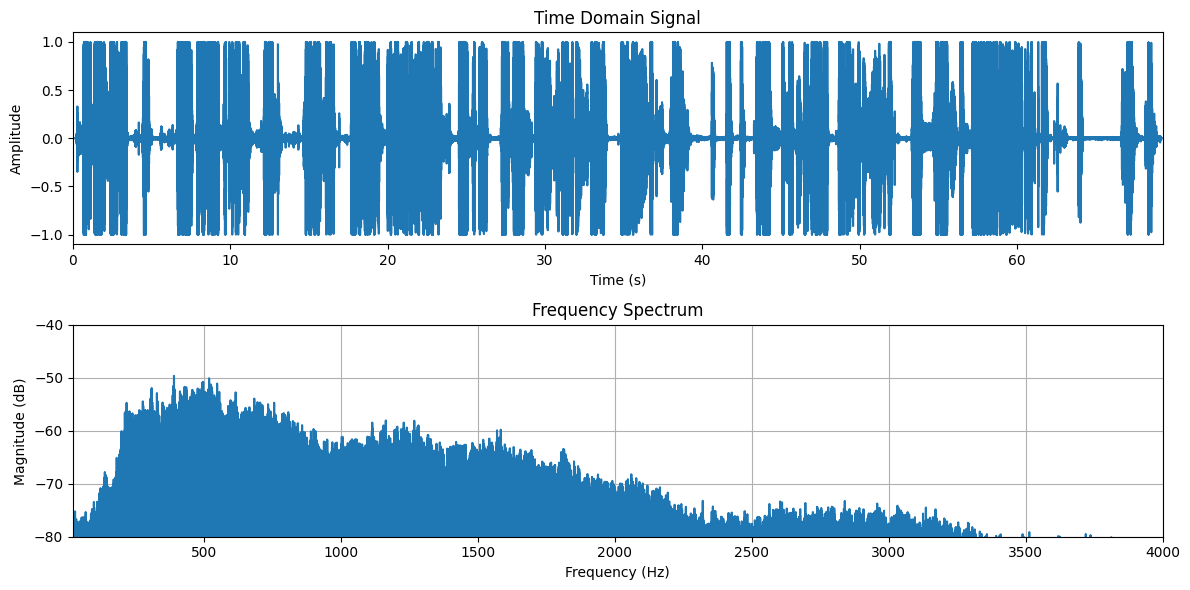

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Load audio file 
sample_rate, audio_data = wavfile.read('/kaggle/input/arabic-natural-audio-dataset/V1.wav')


if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# scaling the signals
audio_data = audio_data / np.max(np.abs(audio_data))


# Time domain 
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
time = np.arange(len(audio_data)) / sample_rate
plt.plot(time, audio_data)
plt.title('Time Domain Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, time[-1])

# Frequency domain 
plt.subplot(2, 1, 2)
n = len(audio_data)
freq = np.fft.rfftfreq(n, d=1/sample_rate) 
fft_result = np.fft.rfft(audio_data) 
magnitude = np.abs(fft_result) / n  

magnitude_db = 20 * np.log10(magnitude + 1e-12) 

plt.plot(freq, magnitude_db)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(20, 4000) # range of human speach 
plt.ylim(-80, -40) 
plt.grid(True)

plt.tight_layout()
plt.show()

### Filters

original Audio:


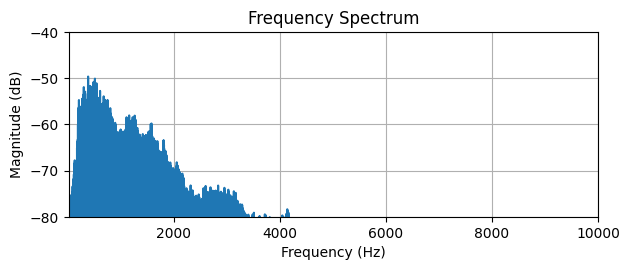

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram, butter, filtfilt
from IPython.display import Audio

fs, data = wavfile.read("/kaggle/input/arabic-natural-audio-dataset/V1.wav")

if len(data.shape) > 1:
    data = data[:, 0]

data = data / np.max(np.abs(data))


data_5s = data[:5 * fs]


print("original Audio:")
display(Audio(data_5s, rate=fs))


plt.subplot(2, 1, 2)
n = len(data)
freq = np.fft.rfftfreq(n, d=1/fs) 
fft_result = np.fft.rfft(data) 
magnitude = np.abs(fft_result) / n  
magnitude_db = 20 * np.log10(magnitude + 1e-12) 

plt.plot(freq, magnitude_db)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(20, 10000) 
plt.ylim(-80, -40) 
plt.grid(True)

plt.tight_layout()
plt.show()


Noisy Audio:


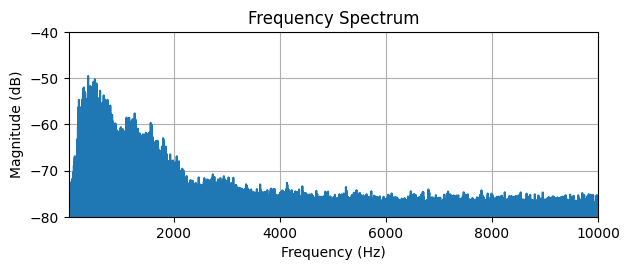

In [9]:
# add Gaussian noise
noise = np.random.normal(0, 0.1*np.max(np.abs(data)), data.shape)
noisy_data = data + noise

print("Noisy Audio:")
display(Audio(noisy_data[:5 * fs], rate=fs))

plt.subplot(2, 1, 2)
n = len(noisy_data)
freq = np.fft.rfftfreq(n, d=1/fs) 
fft_result = np.fft.rfft(noisy_data) 
magnitude = np.abs(fft_result) / n  
magnitude_db = 20 * np.log10(magnitude + 1e-12) 

plt.plot(freq, magnitude_db)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(20, 10000) 
plt.ylim(-80, -40) 
plt.grid(True)

plt.tight_layout()
plt.show()


Filtered Audio:


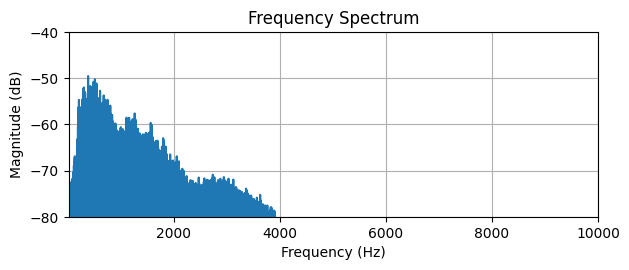

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff_hz = 4000 # human speech
b, a = butter_lowpass(cutoff_hz, fs, order=6)
filtered_data = filtfilt(b, a, noisy_data)

print("Filtered Audio:")
display(Audio(filtered_data[:5 * fs], rate=fs))

plt.subplot(2, 1, 2)
n = len(filtered_data)
freq = np.fft.rfftfreq(n, d=1/fs) 
fft_result = np.fft.rfft(filtered_data) 
magnitude = np.abs(fft_result) / n  
magnitude_db = 20 * np.log10(magnitude + 1e-12) 

plt.plot(freq, magnitude_db)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(20, 10000) 
plt.ylim(-80, -40) 
plt.grid(True)

plt.tight_layout()
plt.show()

## Short time fourier Transformation 

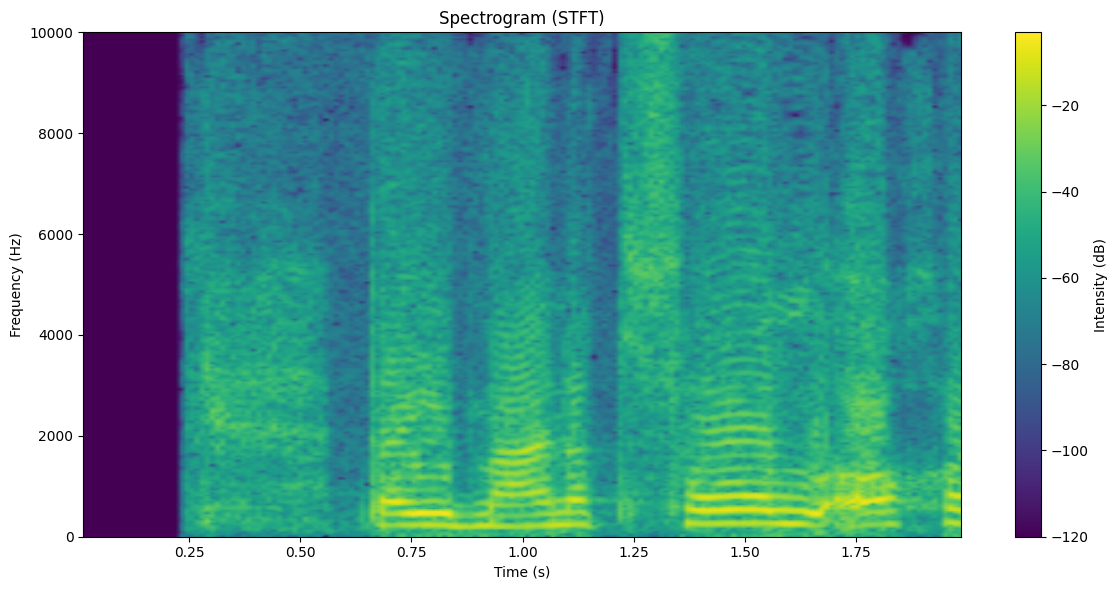

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

sample_rate, audio_data = wavfile.read('/kaggle/input/arabic-natural-audio-dataset/V1.wav')
if len(audio_data.shape) > 1:
    audio_data = audio_data[0:2*sample_rate, 0]

audio_data = audio_data / np.max(np.abs(audio_data))

nperseg = 1024  
noverlap = 512  
freqs, times, Sxx = spectrogram(
    audio_data, 
    fs=sample_rate,
    window='hann', # window type 
    nperseg=nperseg, # number of sampel per segmant
    noverlap=noverlap, # number of point that are overlabed (defualt nperseg // 2)
    scaling='spectrum'  
)

Sxx_db = 10 * np.log10(Sxx + 1e-12)  


plt.figure(figsize=(12, 6))
plt.pcolormesh(times, freqs, Sxx_db, shading='gouraud', cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 10000) 
plt.tight_layout()
plt.show()

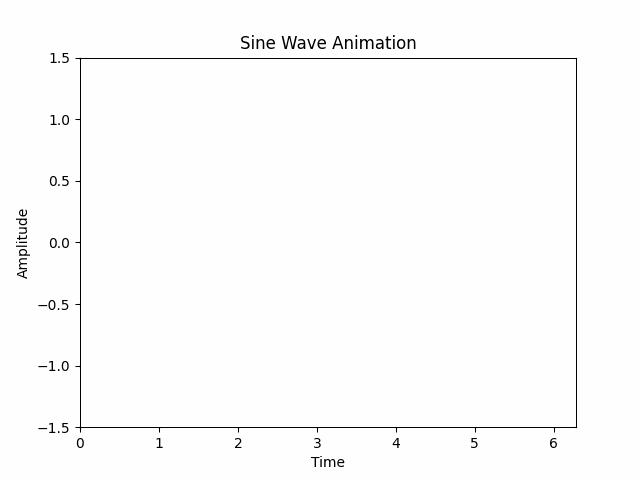

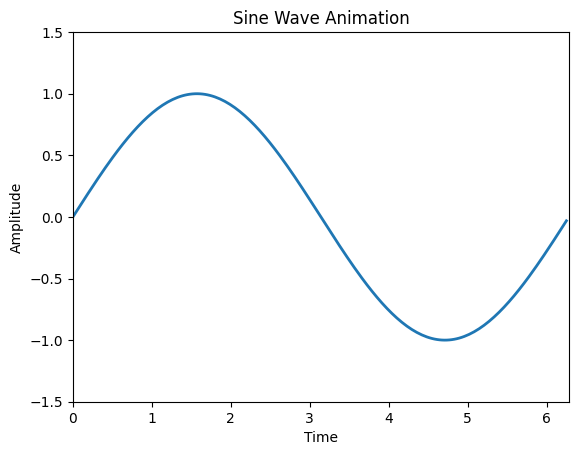

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


t = np.linspace(0, 2*np.pi, 200)


fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Sine Wave Animation')


def init():
    line.set_data([], [])
    return line,


def update(frame):
    x = t[:frame]
    y = np.sin(t[:frame])
    line.set_data(x, y)
    return line,


ani = FuncAnimation(
    fig, 
    update, 
    frames=len(t), 
    init_func=init, 
    interval=50,  
    blit=True
)


ani.save('/kaggle/working/sine_wave.gif', writer=PillowWriter(fps=20))

from IPython.display import Image
Image(filename='/kaggle/working/sine_wave.gif')

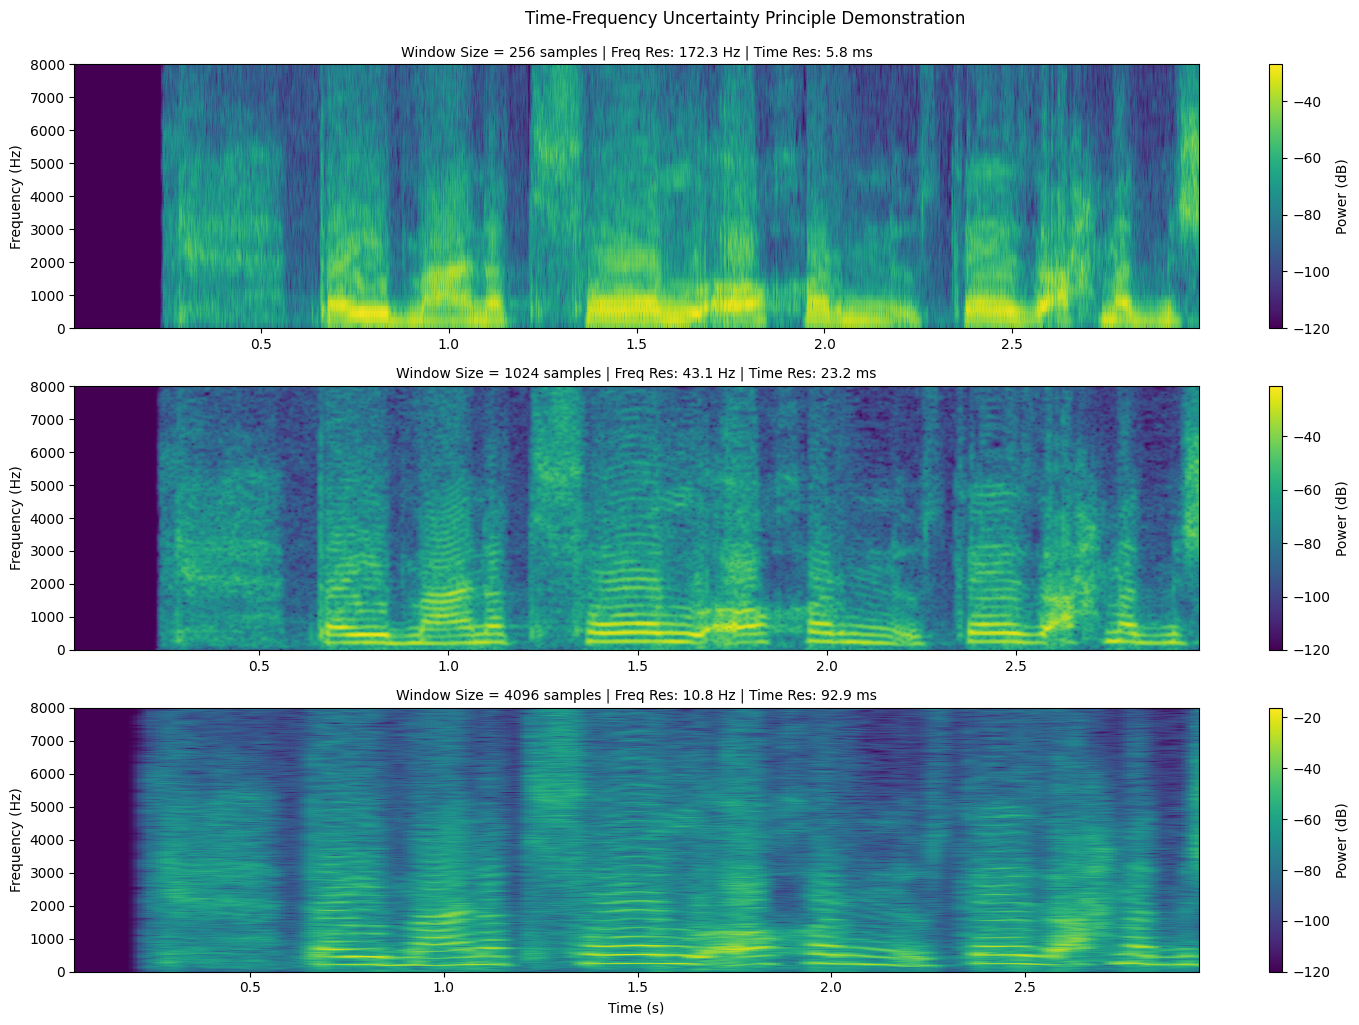

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram


sample_rate, audio_data = wavfile.read('/kaggle/input/arabic-natural-audio-dataset/V1.wav')


if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]


audio_data = audio_data[:int(3*sample_rate)] / np.max(np.abs(audio_data))


window_sizes = [256, 1024, 4096]  
noverlap_factor = 0.75  

plt.figure(figsize=(15, 10))

for i, nperseg in enumerate(window_sizes):
    noverlap = int(nperseg * noverlap_factor)
    
    # Compute STFT
    freqs, times, Sxx = spectrogram(
        audio_data,
        fs=sample_rate,
        window='hann',
        nperseg=nperseg,
        noverlap=noverlap,
        scaling='density'
    )
    Sxx_db = 10 * np.log10(Sxx + 1e-12)
    
    # Calculate theoretical resolution
    freq_resolution = sample_rate / nperseg  
    time_resolution = nperseg / sample_rate  
    
    # Plot spectrogram
    plt.subplot(3, 1, i+1)
    plt.pcolormesh(times, freqs, Sxx_db, shading='gouraud', cmap='viridis')
    plt.colorbar(label='Power (dB)')
    plt.title(
        f'Window Size = {nperseg} samples | '
        f'Freq Res: {freq_resolution:.1f} Hz | '
        f'Time Res: {time_resolution*1000:.1f} ms',
        fontsize=10
    )
    plt.xlabel('Time (s)') if i == 2 else None
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 8000)  

plt.tight_layout()
plt.suptitle('Time-Frequency Uncertainty Principle Demonstration', y=1.02)
plt.show()

### how could we use the spectrogram and STFT in DL 

great feature extractor !!!

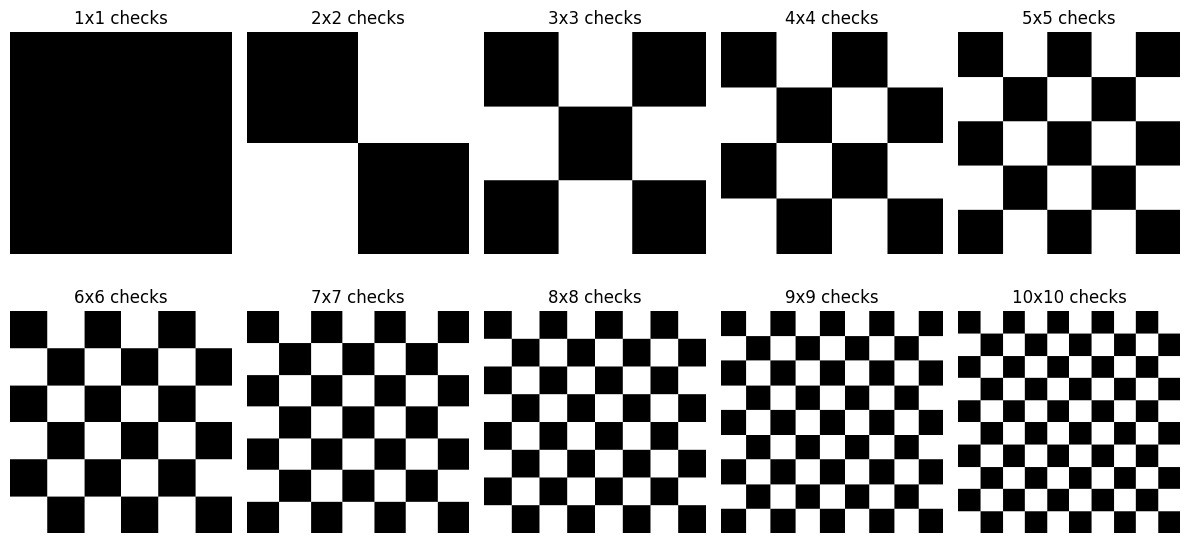

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_checkerboard(size, num_checks):
    row_check = np.floor(np.arange(size) / (size / num_checks)).astype(int)
    col_check = np.floor(np.arange(size) / (size / num_checks)).astype(int)
    board = (row_check[:, None] + col_check[None, :]) % 2  
    return board * 255 


image_size = 256
num_patterns = 10 

checkerboards = []

for checks in range(1, num_patterns + 1):
    cb = generate_checkerboard(image_size, checks)
    checkerboards.append(cb)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for idx, cb in enumerate(checkerboards):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(cb, cmap='gray', vmin=0, vmax=255)
    ax.set_title(f"{idx+1}x{idx+1} checks")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Now checkerboards is a list of numpy arrays

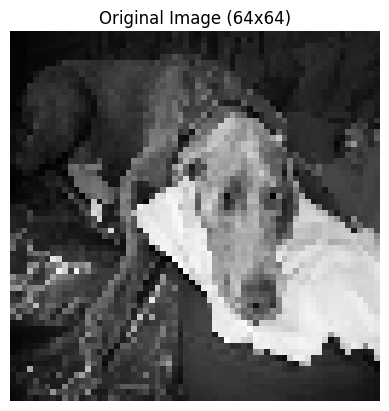

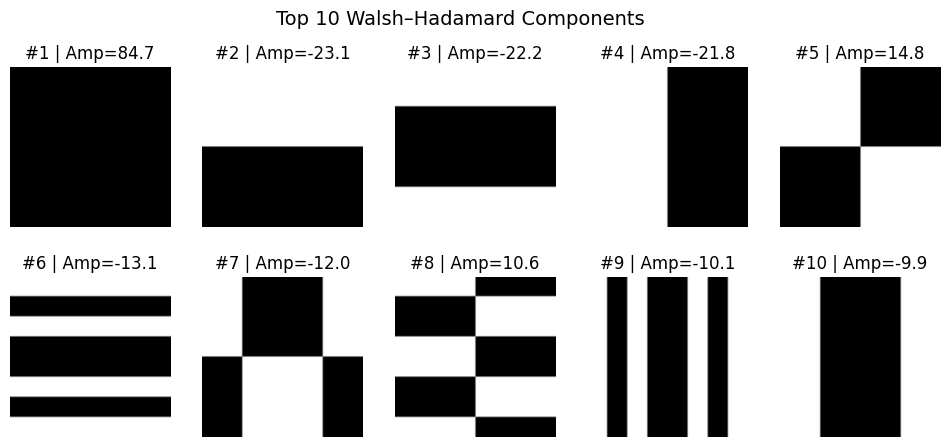

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard

# Walsh–Hadamard 2D basis
def walsh_hadamard_2d_basis(n):
    H = hadamard(n)
    basis = []
    for i in range(n):
        for j in range(n):
            pattern = np.outer(H[i], H[j])
            basis.append(pattern)
    return basis


img = cv2.imread("/kaggle/input/stanford-dogs-dataset/images/Images/n02092339-Weimaraner/n02092339_235.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))
img_f = img.astype(float)

# Show original image
plt.imshow(img, cmap="gray")
plt.title("Original Image (64x64)")
plt.axis("off")
plt.show()


basis_patterns = walsh_hadamard_2d_basis(img.shape[0])
components = []
for pattern in basis_patterns:
    amp = np.sum(img_f * pattern) / (img.shape[0] * img.shape[1])
    components.append((amp, pattern))


components.sort(key=lambda x: abs(x[0]), reverse=True)


fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    amp, pattern = components[i]
    axes[i//5, i%5].imshow(pattern, cmap="gray")
    axes[i//5, i%5].set_title(f"#{i+1} | Amp={amp:.1f}")
    axes[i//5, i%5].axis("off")
plt.suptitle("Top 10 Walsh–Hadamard Components", fontsize=14)
plt.show()


h, w = img.shape
reconstruction = np.zeros((h, w), dtype=float)

video_writer = cv2.VideoWriter(
    "checkerboard_reconstruction_fast.avi",
    cv2.VideoWriter_fourcc(*"XVID"),
    10,  
    (w, h),
    False
)

for idx in range(0, len(components), 10):  
    for amp, pattern in components[idx:idx+10]:
        reconstruction += amp * pattern
    disp = reconstruction - reconstruction.min()
    disp = (disp / disp.max() * 255).astype(np.uint8)
    video_writer.write(disp)

video_writer.release()

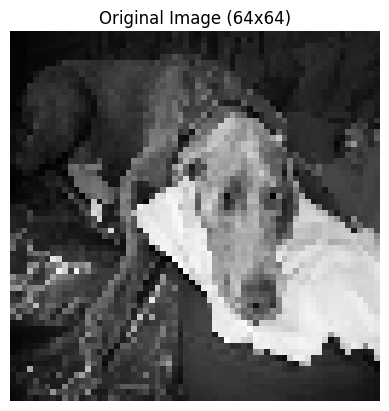

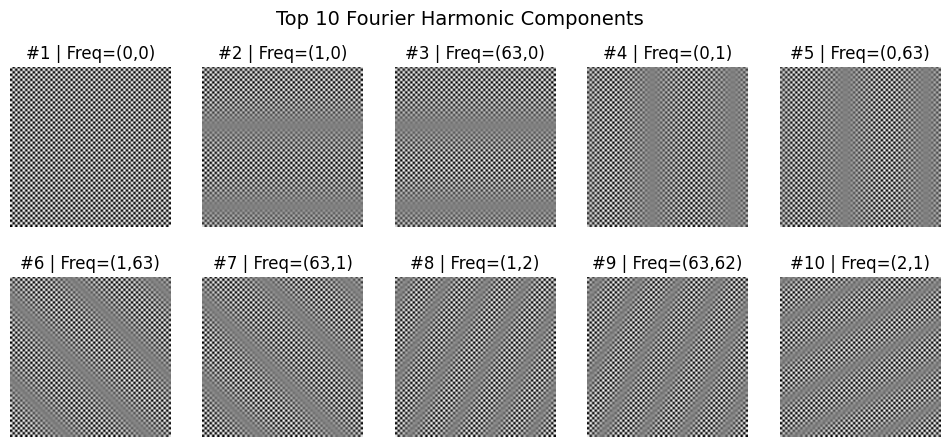

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


img = cv2.imread("/kaggle/input/stanford-dogs-dataset/images/Images/n02092339-Weimaraner/n02092339_235.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (64, 64))
img_f = np.float32(img)


plt.imshow(img, cmap="gray")
plt.title("Original Image (64x64)")
plt.axis("off")
plt.show()

# 2D fft
F = np.fft.fft2(img_f)
F_shifted = np.fft.fftshift(F)



h, w = img.shape
coords = [(u, v) for u in range(h) for v in range(w)]
coords.sort(key=lambda c: abs(F_shifted[c]), reverse=True)


fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    u, v = coords[i]
    pattern = np.zeros_like(F_shifted, dtype=complex)
    pattern[u, v] = F_shifted[u, v]
    img_pattern = np.fft.ifft2(np.fft.ifftshift(pattern)).real
    img_pattern = cv2.normalize(img_pattern, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    axes[i//5, i%5].imshow(img_pattern, cmap="gray")
    axes[i//5, i%5].set_title(f"#{i+1} | Freq=({u},{v})")
    axes[i//5, i%5].axis("off")
plt.suptitle("Top 10 Fourier Harmonic Components", fontsize=14)
plt.show()


reconstruction = np.zeros_like(F_shifted, dtype=complex)

video_writer = cv2.VideoWriter(
    "harmonic_reconstruction_fast.avi",
    cv2.VideoWriter_fourcc(*"XVID"),
    10,
    (w, h),
    False
)

for idx in range(0, len(coords), 10):  
    for u, v in coords[idx:idx+10]:
        reconstruction[u, v] = F_shifted[u, v]
    img_rec = np.fft.ifft2(np.fft.ifftshift(reconstruction)).real
    img_disp = cv2.normalize(img_rec, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    video_writer.write(img_disp)

video_writer.release()

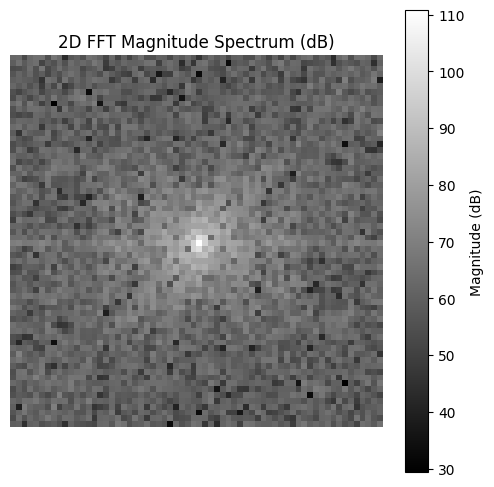

In [5]:
magnitude_spectrum = np.abs(F_shifted)
magnitude_db = 20 * np.log10(magnitude_spectrum + 1e-8) 

plt.figure(figsize=(6, 6))
plt.imshow(magnitude_db, cmap="gray")
plt.title("2D FFT Magnitude Spectrum (dB)")
plt.colorbar(label="Magnitude (dB)")
plt.axis("off")
plt.show()


### simple JPEG demo and DCT energy compaction 

(333, 500)
(333, 500)


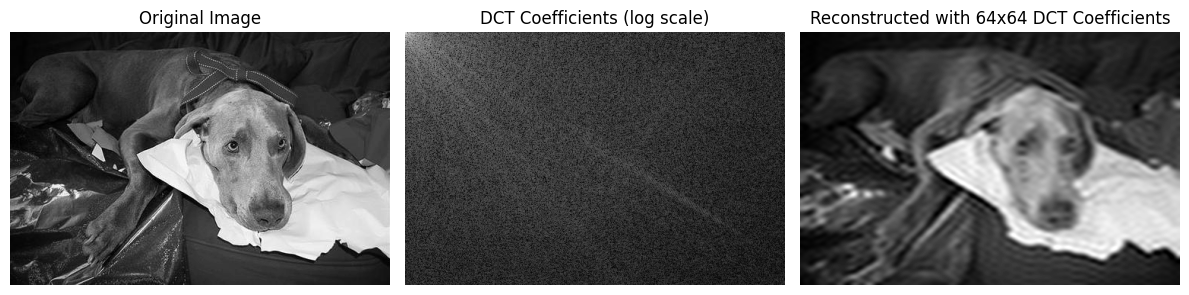

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct


def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


path = "/kaggle/input/stanford-dogs-dataset/images/Images/n02092339-Weimaraner/n02092339_235.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = np.float32(img)
print(img.shape)
dct_transformed = dct2(img)
dct_transformed

N = 64  
compressed_dct = np.zeros_like(dct_transformed)
print(compressed_dct.shape)
compressed_dct[:N, :N] = dct_transformed[:N, :N]


img_reconstructed = idct2(compressed_dct)
img_reconstructed = np.clip(img_reconstructed, 0, 255)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.log(abs(dct_transformed) + 1), cmap='gray')
plt.title("DCT Coefficients (log scale)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.uint8(img_reconstructed), cmap='gray')
plt.title(f"Reconstructed with {N}x{N} DCT Coefficients")
plt.axis("off")

plt.tight_layout()
plt.show()

### ORIGIAL JPEG IDEA 8X8 BLOCKS

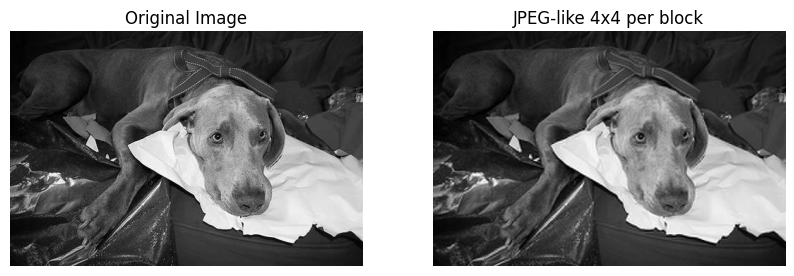

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


img = cv2.imread("/kaggle/input/stanford-dogs-dataset/images/Images/n02092339-Weimaraner/n02092339_235.jpg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Image not found")
img = np.float32(img)


block_size = 8
keep_coeff = 4  

h, w = img.shape
compressed_img = np.zeros_like(img)

for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = img[i:i+block_size, j:j+block_size]
        dct_block = dct2(block)
        
        
        mask = np.zeros_like(dct_block)
        mask[:keep_coeff, :keep_coeff] = 1
        dct_block *= mask
        compressed_img[i:i+block_size, j:j+block_size] = idct2(dct_block)


compressed_img = np.clip(compressed_img, 0, 255).astype(np.uint8)

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(compressed_img, cmap='gray')
plt.title(f"JPEG-like {keep_coeff}x{keep_coeff} per block")
plt.axis("off")

plt.show()

# Signal from the point of view of Statistics  

# Covariance, Correlation, and Autocorrelation

### 1. Covariance
For two signals $$(x(t))$$ and $$(y(t))$$:

- **Continuous case**  
$$
\mathrm{Cov}(x,y) = \frac{1}{T} \int_{0}^{T} \Big(x(t) - \bar{x}\Big)\Big(y(t) - \bar{y}\Big)\, dt
$$

- **Discrete case**  
$$
\mathrm{Cov}(x,y) = \frac{1}{N} \sum_{n=0}^{N-1} \Big(x[n] - \bar{x}\Big)\Big(y[n] - \bar{y}\Big)
$$

where $$(\bar{x})$$ and $$(\bar{y})$$ are the average values of $$(x)$$ and $$(y)$$.

---

### 2. Correlation (normalized covariance)
$$
\mathrm{Corr}(x,y) = \frac{\mathrm{Cov}(x,y)}{\sigma_x \, \sigma_y}
$$

where $$(\sigma_x$$) and $$(\sigma_y)$$ are the standard deviations of $$(x)$$ and $$(y)$$.

---

### 3. Autocorrelation
This measures similarity of a signal with a shifted version of itself.

- **Continuous case**  
$$
R_{xx}(\tau) = \frac{1}{T} \int_{0}^{T} x(t)\,x(t+\tau)\,dt
$$

- **Discrete case**  
$$
R_{xx}[k] = \frac{1}{N} \sum_{n=0}^{N-1} x[n] \, x[n+k]
$$

where \(k\) (or \(\tau\)) is the shift (lag).

---

### 4. Autocorrelation Matrix (R-matrix)
For a discrete signal vector
$$
x = [x[0], x[1], \dots, x[N-1]]^T
$$

the autocorrelation matrix is:

$$
R = E[x \, x^T]
$$

or more "sum-based":

$$
R = \frac{1}{N} \sum_{n=0}^{N-1} x_n \, x_n^T
$$

which results in a symmetric Toeplitz matrix:

$$
R =
\begin{bmatrix}
R_{xx}[0] & R_{xx}[1] & R_{xx}[2] & \dots \\
R_{xx}[-1] & R_{xx}[0] & R_{xx}[1] & \dots \\
R_{xx}[-2] & R_{xx}[-1] & R_{xx}[0] & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

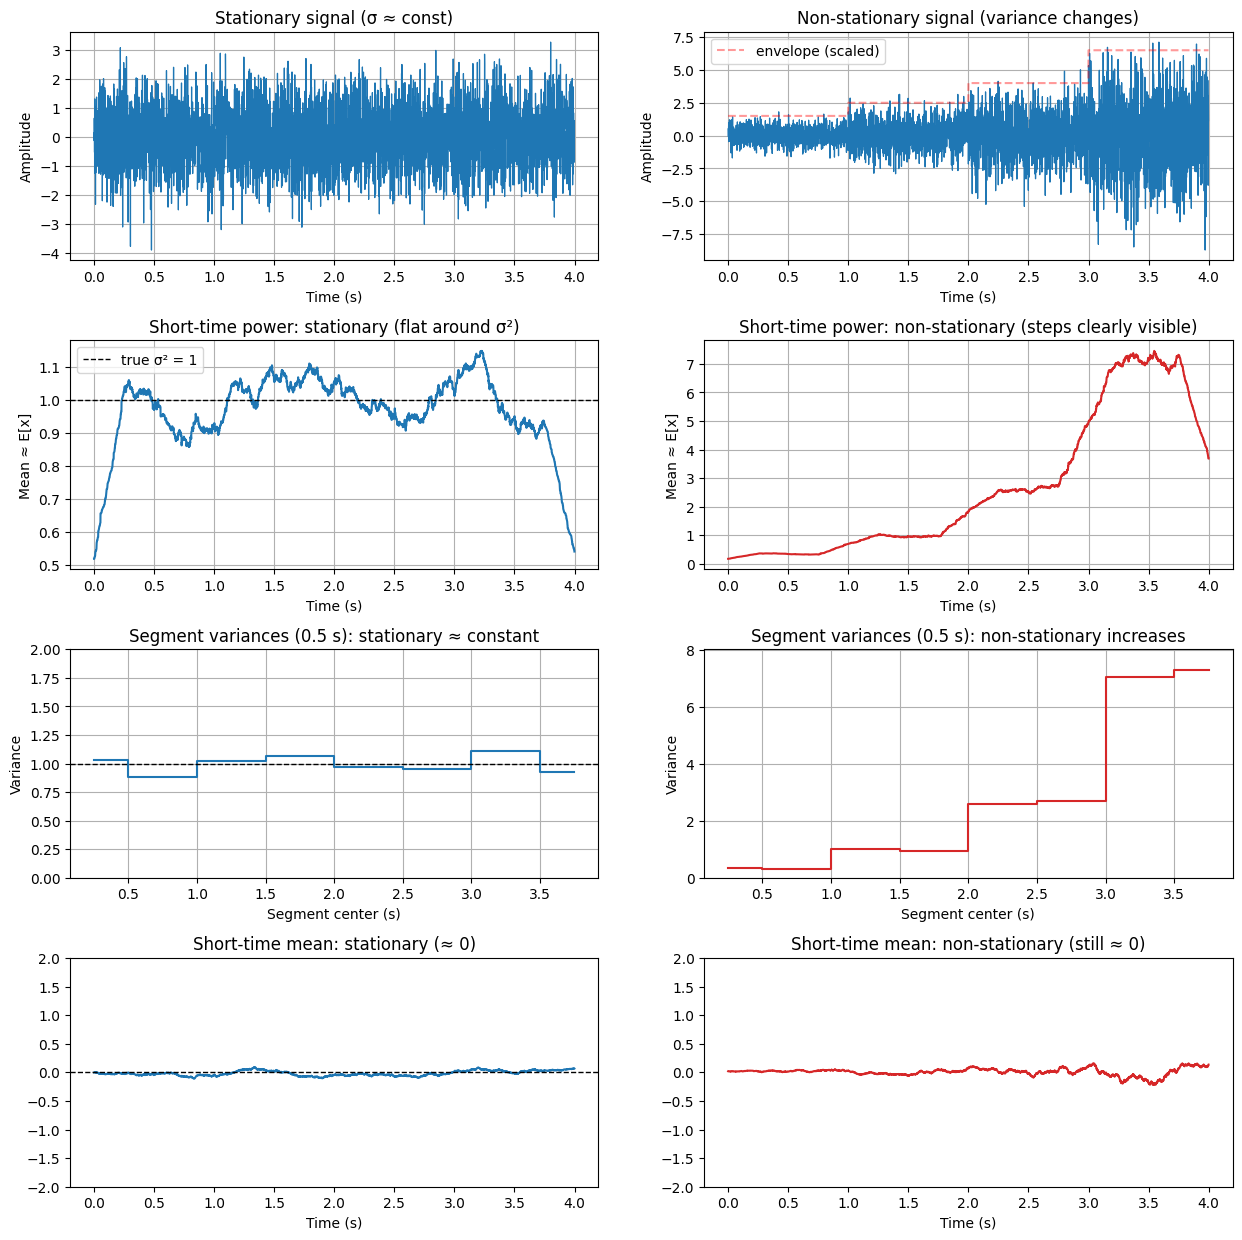

In [11]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)


fs = 1000                
T  = 4.0                  
t  = np.arange(int(fs*T))/fs

# stationary zero mean, constant variance σ^2 = 1
x_stat = rng.normal(0, 1.0, len(t))

# non-stationary: same noise * stepwise-growing envelope
env = np.piecewise(t,
                   [t < 1, (t >= 1) & (t < 2), (t >= 2) & (t < 3), t >= 3],
                   [0.6, 1.0, 1.6, 2.6])     
x_nstat = rng.normal(0, 1.0, len(t)) * env


def short_time_power(x, fs, win_sec=0.25):
    N = max(1, int(win_sec*fs))
    kernel = np.ones(N)/N
    return np.convolve(x**2, kernel, mode='same')

stp_stat  = short_time_power(x_stat,  fs, win_sec=0.5)   
stp_nstat = short_time_power(x_nstat, fs, win_sec=0.5)

def short_time_mean(x, fs, win_sec=0.25):
    N = max(1, int(win_sec*fs))
    kernel = np.ones(N)/N
    return np.convolve(x, kernel, mode='same')   

stm_stat  = short_time_mean(x_stat,  fs, win_sec=0.5)   
stm_nstat = short_time_mean(x_nstat, fs, win_sec=0.5)

def segment_variances(x, fs, seg_sec=1):
    N = int(seg_sec*fs)
    nseg = len(x)//N
    vars_ = [np.var(x[k*N:(k+1)*N]) for k in range(nseg)]
    times = np.arange(nseg)*seg_sec + seg_sec/2
    return np.array(times), np.array(vars_)

seg_t_stat,  seg_var_stat  = segment_variances(x_stat,  fs, seg_sec=0.5)
seg_t_nstat, seg_var_nstat = segment_variances(x_nstat, fs, seg_sec=0.5)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(4, 2, height_ratios=[1.1, 1.1, 1.1, 1.1], hspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])

# Time series
ax1.plot(t, x_stat, lw=0.9)
ax1.set_title("Stationary signal (σ ≈ const)")
ax1.set_xlabel("Time (s)"); ax1.set_ylabel("Amplitude"); ax1.grid(True)

ax2.plot(t, x_nstat, lw=0.9)
ax2.plot(t, env*2.5, 'r--', alpha=0.4, label="envelope (scaled)")
ax2.set_title("Non-stationary signal (variance changes)")
ax2.set_xlabel("Time (s)"); ax2.set_ylabel("Amplitude"); ax2.grid(True); ax2.legend()

# Short-time power
ax3.plot(t, stp_stat, lw=1.5)
ax3.axhline(1.0, color='k', ls='--', lw=1, label="true σ² = 1")
ax3.set_title("Short-time power: stationary (flat around σ²)")
ax3.set_xlabel("Time (s)"); ax3.set_ylabel("Power ≈ E[x²]"); ax3.grid(True); ax3.legend()

ax4.plot(t, stp_nstat, lw=1.5, color='C3')
ax4.set_title("Short-time power: non-stationary (steps clearly visible)")
ax4.set_xlabel("Time (s)"); ax4.set_ylabel("Power ≈ E[x²]"); ax4.grid(True)

# Segment-wise variances (bar/step)
ax5.step(seg_t_stat,  seg_var_stat,  where='mid')
ax5.axhline(1.0, color='k', ls='--', lw=1)
ax5.set_title("Segment variances (0.5 s): stationary ≈ constant")
ax5.set_xlabel("Segment center (s)"); ax5.set_ylabel("Variance"); ax5.grid(True)
ax5.set_ylim(0, max(2, 1.1*np.max(seg_var_stat)))

ax6.step(seg_t_nstat, seg_var_nstat, where='mid', color='C3')
ax6.set_title("Segment variances (0.5 s): non-stationary increases")
ax6.set_xlabel("Segment center (s)"); ax6.set_ylabel("Variance"); ax6.grid(True)
ax6.set_ylim(0, 1.1*np.max(seg_var_nstat))

ax7.plot(t, stm_stat, lw=1.5)
ax7.axhline(0.0, color='k', ls='--', lw=1, label="true mean = 0")
ax7.set_title("Short-time mean: stationary (≈ 0)")
ax7.set_xlabel("Time (s)"); ax3.set_ylabel("Mean ≈ E[x]"); ax3.grid(True); ax3.legend()
ax7.set_ylim([-2, 2])

ax8.plot(t, stm_nstat, lw=1.5, color='C3')
ax8.set_title("Short-time mean: non-stationary (still ≈ 0)")
ax8.set_xlabel("Time (s)"); ax4.set_ylabel("Mean ≈ E[x]"); ax4.grid(True)
ax8.set_ylim([-2, 2])


plt.show()



In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as spsig
from scipy.signal import correlate, correlation_lags
from ipywidgets import interact, Dropdown, FloatSlider, Checkbox, IntSlider, fixed


def make_signal(kind, t, fs):
    if kind == "sine 5 Hz":
        return np.sin(2*np.pi*5*t)
    if kind == "sine 8 Hz":
        return np.sin(2*np.pi*8*t)
    if kind == "square 5 Hz":
        return spsig.square(2*np.pi*5*t, duty=0.5)
    if kind == "chirp 5→15 Hz":
        return spsig.chirp(t, f0=5, f1=15, t1=t[-1], method="linear")
    if kind == "pulse train 5 Hz (20% duty)":
        return spsig.square(2*np.pi*5*t, duty=0.2) * 0.9
    if kind == "white noise":
        rng = np.random.default_rng(0)
        return rng.normal(0, 1, len(t))
    if kind == "sine 5 Hz + noise":
        rng = np.random.default_rng(0)
        return np.sin(2*np.pi*5*t) + 0.4*rng.normal(0, 1, len(t))
    raise ValueError("Unknown signal kind")

def frac_shift(y, t, shift_s):
    tt = t - shift_s
    return np.interp(t, tt, y, left=0, right=0)

def normalized_correlation(in1, in2, fs):
    x = in1 - np.mean(in1)
    y = in2 - np.mean(in2)
    sx = np.std(x); sy = np.std(y)
    sx = sx if sx > 1e-12 else 1e-12
    sy = sy if sy > 1e-12 else 1e-12
    r = correlate(y, x, mode='full') / (sx*sy*len(x))  
    lags = correlation_lags(len(y), len(x), mode='full') / fs
    return r, lags


def demo(mode="Cross-correlation",
         sig_x="sine 5 Hz",
         sig_y="sine 8 Hz",
         delay_ms=60.0,
         fs=500,
         duration_s=2.0,
         noise_std=0.15,
         maxlag_s=0.5,
         lag_slider=0.0):

    fs = int(fs)
    t = np.arange(int(duration_s*fs)) / fs
    x = make_signal(sig_x, t, fs)

    y = make_signal(sig_y, t, fs)
    if mode == "Auto-correlation (linked copy)":
        y = frac_shift(x, t, delay_ms/1000.0)
        rng = np.random.default_rng(1)
        y = y + noise_std*rng.normal(0, 1, len(t))

    if mode == "Correlation heatmap":
        all_signals = ["sine 5 Hz", "sine 8 Hz", "square 5 Hz",
                       "chirp 5→15 Hz", "pulse train 5 Hz (20% duty)",
                       "white noise", "sine 5 Hz + noise"]

        fig, ax = plt.subplots(figsize=(8,5))
        lags = None
        corr_matrix = []

        for sig_kind in all_signals:
            ysig = make_signal(sig_kind, t, fs)
            r, lags = normalized_correlation(x, ysig, fs)
            mask = (lags >= -maxlag_s) & (lags <= maxlag_s)
            corr_matrix.append(r[mask])

        corr_matrix = np.array(corr_matrix)
        im = ax.imshow(corr_matrix, aspect="auto", extent=[lags[mask][0], lags[mask][-1], 0, len(all_signals)],
                       origin="lower", cmap="coolwarm", vmin=-1, vmax=1)
        ax.set_yticks(np.arange(len(all_signals))+0.5)
        ax.set_yticklabels(all_signals)
        ax.set_xlabel("Lag (s)")
        ax.set_title(f"Correlation of {sig_x} vs others")
        fig.colorbar(im, ax=ax, label="Correlation")
        plt.show()
        return

    r, lags = normalized_correlation(y, x, fs)
    mask = (lags >= -maxlag_s) & (lags <= maxlag_s)
    lags_v = lags[mask]; r_v = r[mask]

    closest_idx = np.argmin(np.abs(lags_v - lag_slider))
    r_at_slider = r_v[closest_idx]
    y_shifted = frac_shift(y, t, lag_slider)

    fig, axes = plt.subplots(3, 1, figsize=(10,9))
    ax0, ax1, ax2 = axes

    ax0.plot(t, x, label="x(t)")
    ax0.plot(t, y, label="y(t)", alpha=0.8)
    ax0.set_title("Time domain signals")
    ax0.set_xlabel("Time (s)"); ax0.set_ylabel("Amplitude")
    ax0.legend(); ax0.grid(True)

    ax1.plot(lags_v, r_v, lw=1.5)
    ax1.axvline(0, color='k', ls='--')
    ax1.plot(lag_slider, r_at_slider, 'o', color='tab:red')
    ax1.set_title("Cross-correlation (y vs x)")
    ax1.set_xlabel("Lag (s)")
    ax1.set_ylabel("Correlation")
    ax1.grid(True)
    ax1.text(0.02, 0.9, f"r = {r_at_slider:+.3f} at lag {lag_slider*1000:.0f} ms",
             transform=ax1.transAxes, bbox=dict(boxstyle="round", fc="w"))

    # Bottom plot
    ax2.plot(t, x, label="x(t)")
    ax2.plot(t, y_shifted, label=f"y(t) shifted by {lag_slider*1000:.0f} ms")
    ax2.set_title("Signal overlap at chosen lag")
    ax2.set_xlabel("Time (s)"); ax2.set_ylabel("Amplitude")
    ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()


interact(
    demo,
    mode=Dropdown(options=["Auto-correlation (linked copy)", 
                           "Cross-correlation (manual sliding)",
                           "Correlation heatmap"],
                  value="Auto-correlation (linked copy)"),
    sig_x=Dropdown(options=["sine 5 Hz", "sine 8 Hz", "square 5 Hz",
                            "chirp 5→15 Hz", "pulse train 5 Hz (20% duty)",
                            "white noise", "sine 5 Hz + noise"], value="sine 5 Hz"),
    sig_y=Dropdown(options=["sine 5 Hz", "sine 8 Hz", "square 5 Hz",
                            "chirp 5→15 Hz", "pulse train 5 Hz (20% duty)",
                            "white noise", "sine 5 Hz + noise"], value="sine 8 Hz"),
    delay_ms=FloatSlider(min=-300, max=300, step=5, value=60, description="Delay (linked copy)"),
    fs=FloatSlider(min=200, max=2000, step=100, value=500, description="Fs (Hz)"),
    duration_s=FloatSlider(min=1.0, max=6.0, step=0.5, value=2.0, description="Duration (s)"),
    noise_std=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.15, description="Noise std"),
    maxlag_s=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.5, description="Max lag"),
    lag_slider=FloatSlider(min=-0.5, max=0.5, step=0.01, value=0.0, description="Manual lag (s)")
);

interactive(children=(Dropdown(description='mode', options=('Auto-correlation (linked copy)', 'Cross-correlati…

### covariance matrix and EEG signal

![EEG Electrodes](https://brainlatam.com/uploads/tinymce/a-brief-introduction-to-eeg-and-the-types-of-electrodes-2.webp)


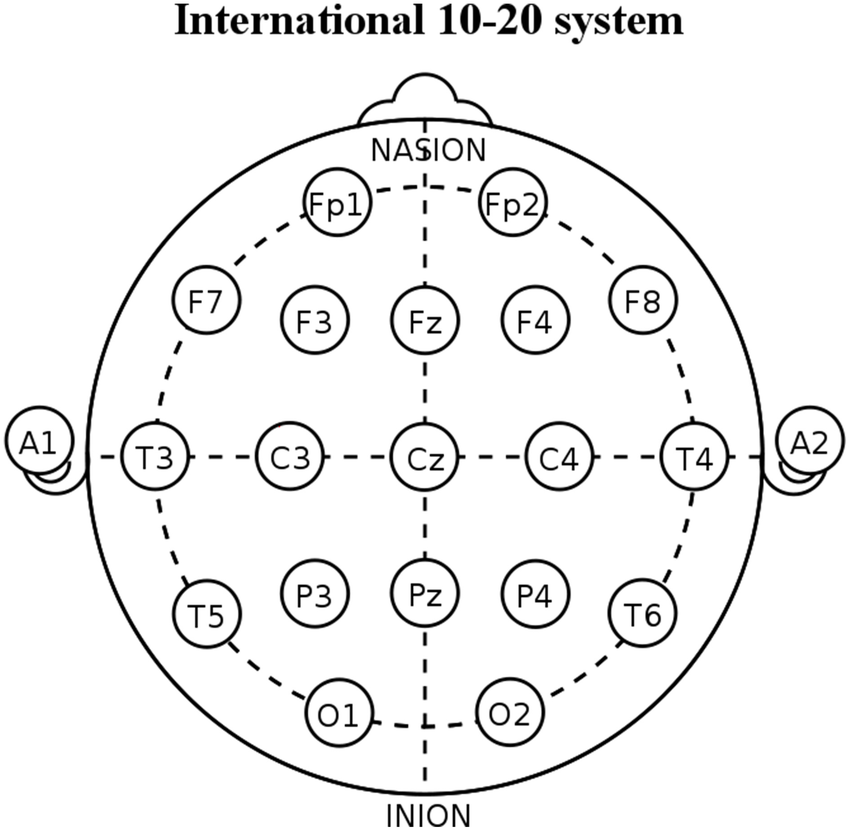
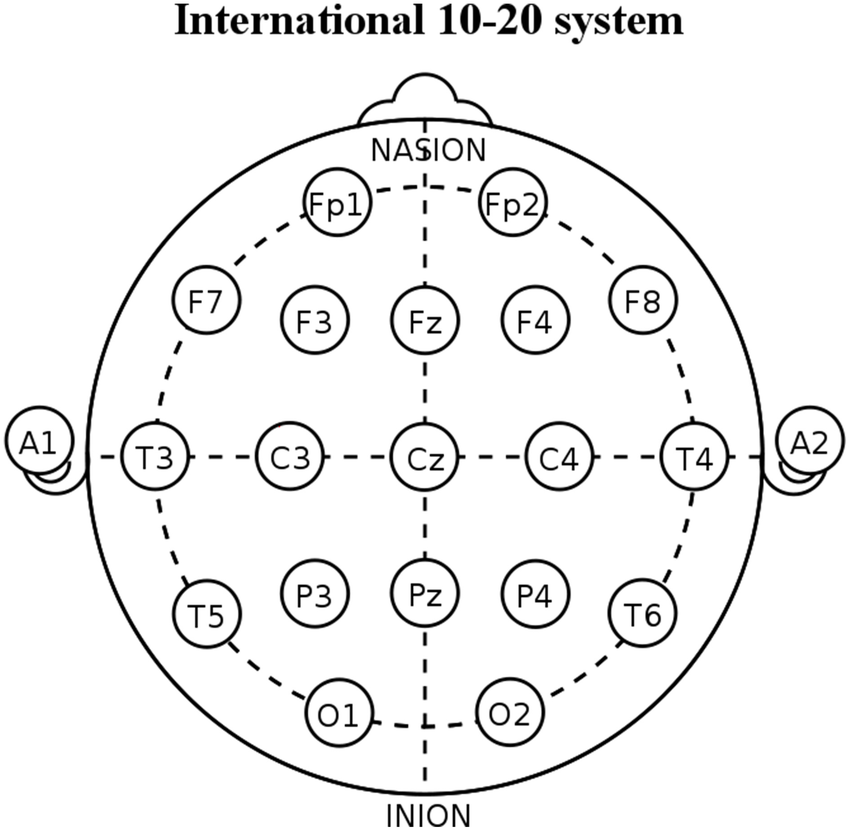

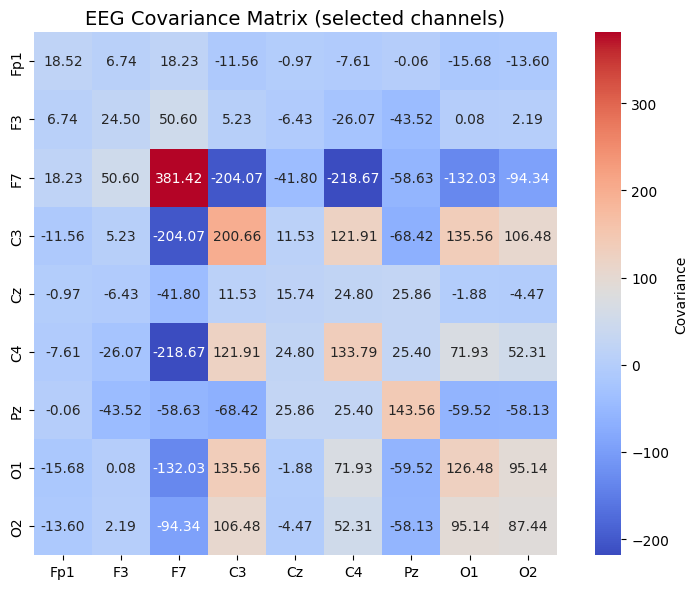

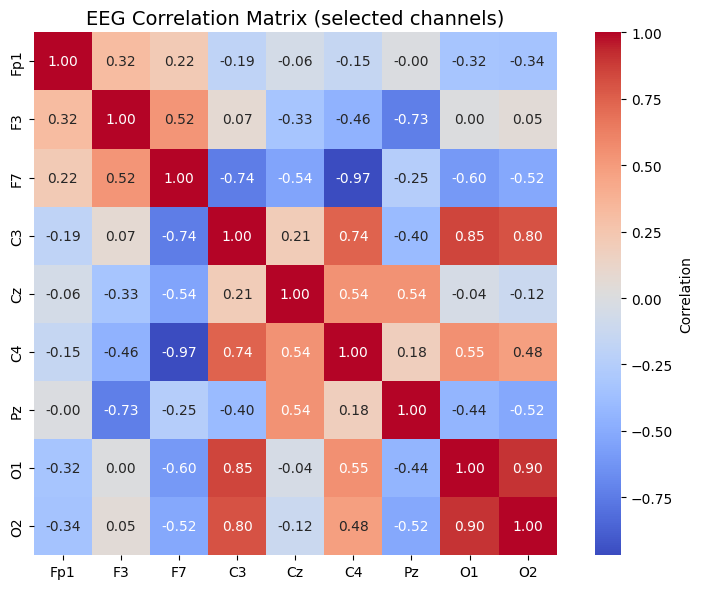

In [2]:
import pandas as pd
df_eeg = pd.read_csv('/kaggle/input/eeg-dataset/features_raw.csv')

import seaborn as sns
import matplotlib.pyplot as plt

channels = ["Fp1", "F3", "F7", "C3", "Cz", "C4", "Pz", "O1", "O2"]


cov_matrix = df_eeg[channels].cov()


plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix, xticklabels=channels, yticklabels=channels,
            cmap="coolwarm", annot=True, fmt=".2f", square=True,
            cbar_kws={'label': 'Covariance'})
plt.title("EEG Covariance Matrix (selected channels)", fontsize=14)
plt.tight_layout()


corr_matrix = df_eeg[channels].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, xticklabels=channels, yticklabels=channels,
            cmap="coolwarm", annot=True, fmt=".2f", square=True,
            cbar_kws={'label': 'Correlation'})
plt.title("EEG Correlation Matrix (selected channels)", fontsize=14)
plt.tight_layout()
plt.show()

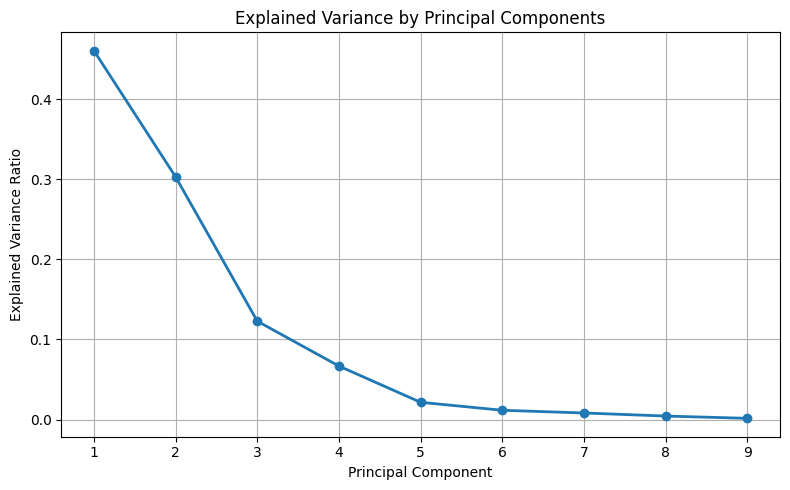

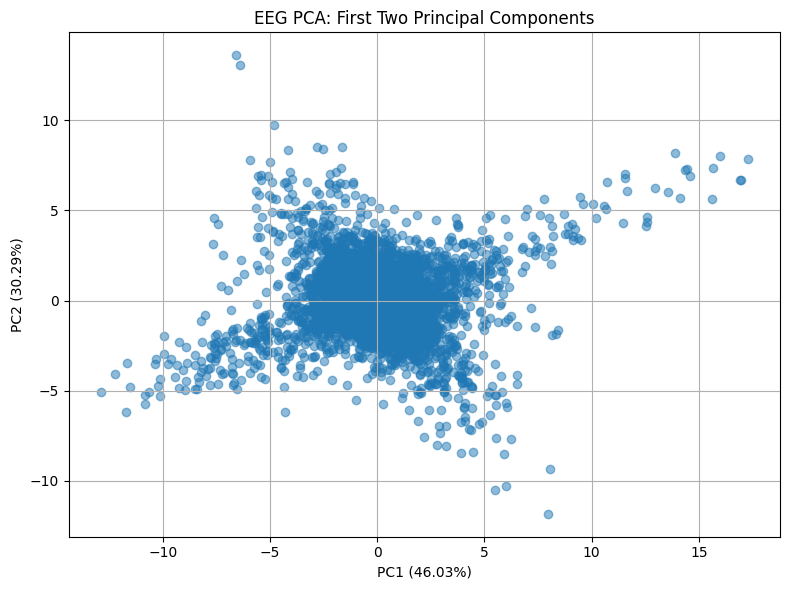

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_eeg = pd.read_csv('/kaggle/input/eeg-dataset/features_raw.csv')
channels = ["Fp1", "F3", "F7", "C3", "Cz", "C4", "Pz", "O1", "O2"]
X = df_eeg[channels] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(channels)+1), pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of first two PCs
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1 (%.2f%%)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (%.2f%%)" % (pca.explained_variance_ratio_[1]*100))
plt.title("EEG PCA: First Two Principal Components")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


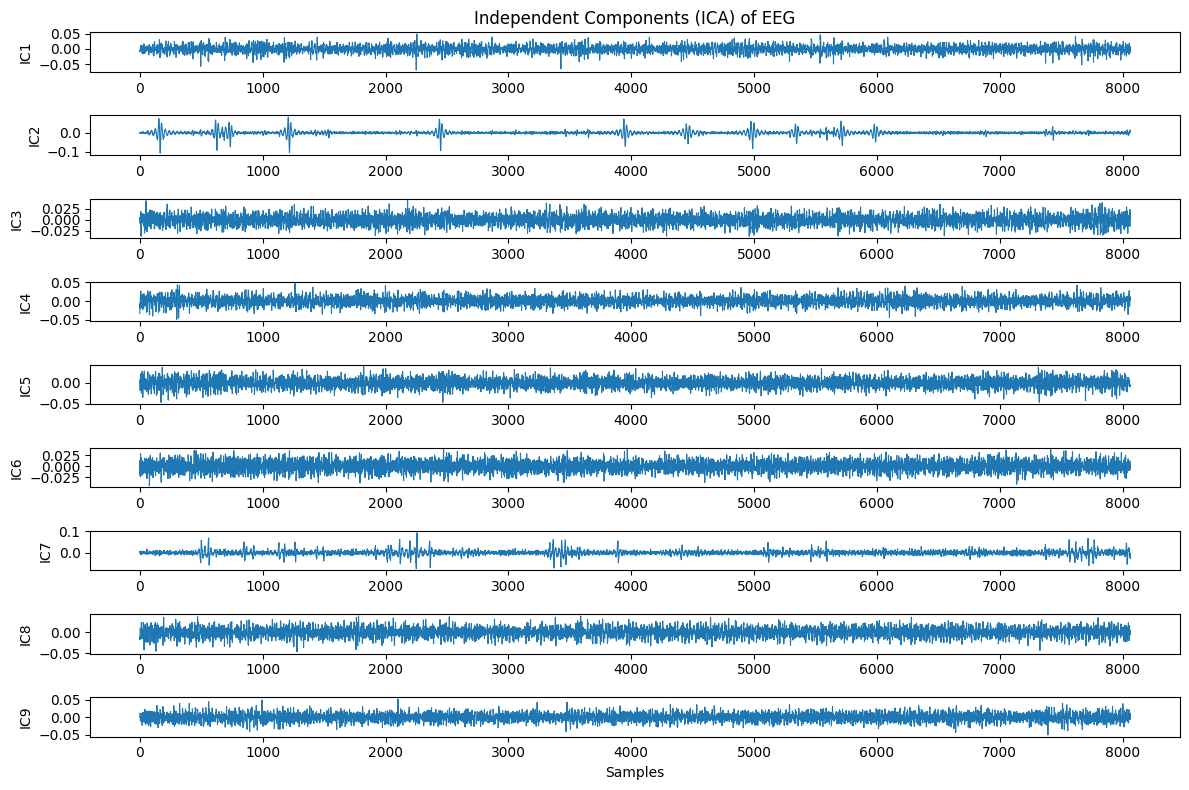

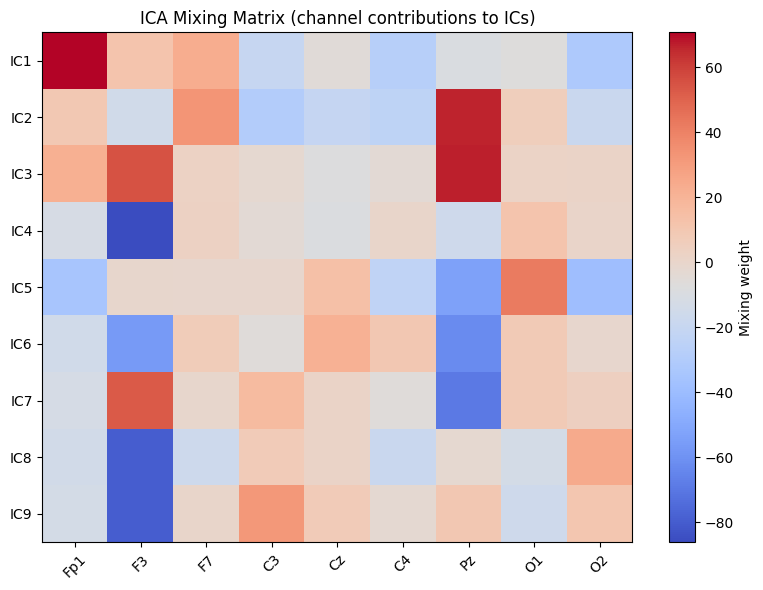

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

df_eeg = pd.read_csv('/kaggle/input/eeg-dataset/features_raw.csv')
channels = ["Fp1", "F3", "F7", "C3", "Cz", "C4", "Pz", "O1", "O2"]
X = df_eeg[channels].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


n_components = len(channels)  
ica = FastICA(n_components=n_components, random_state=42)
X_ica = ica.fit_transform(X_scaled)


plt.figure(figsize=(12, 8))
for i in range(n_components):
    plt.subplot(n_components, 1, i+1)
    plt.plot(X_ica[:, i], linewidth=0.8)
    plt.ylabel(f"IC{i+1}")
    if i == 0:
        plt.title("Independent Components (ICA) of EEG")
plt.xlabel("Samples")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,6))
plt.imshow(ica.mixing_, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Mixing weight")
plt.xticks(range(len(channels)), channels, rotation=45)
plt.yticks(range(n_components), [f"IC{i+1}" for i in range(n_components)])
plt.title("ICA Mixing Matrix (channel contributions to ICs)")
plt.tight_layout()
plt.show()
